# NYConcerts - Roy Prigat
- Web Scraping to find details on NY concerts (based on songkick.com)
- Information is stored in a database
- Using various python modules, the data is then visually displayed.

In [72]:
import sys
sys.version

'3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [73]:
import urllib.request
from bs4 import BeautifulSoup

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 

import numpy as np
import pandas as pd
import sqlite3
import random
import os
import collections
import re
import string
import bs4
import lxml
import datetime

songkick = 'http://www.songkick.com/metro_areas/7644-us-new-york?page='

In [74]:
#convert all month names to number representation

mConvert = {"January": "01", "February": "02", "March": "03", "April": "04",
            "May": "05", "June": "06", "July": "07", "August": "08",
            "September": "09", "October": "10", "November": "11", "December": "12"}

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [75]:
#eliminate weekday names from extracted dates

bannedWord = ['Sunday', 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday']
re_banned_words = re.compile(r"\b(" + "|".join(bannedWord) + ")\\W", re.I)
def RemoveBannedWords(toPrint):
    global re_banned_words
    return re_banned_words.sub("", toPrint)

In [76]:
#finds maximum number of web pages that can be scraped from songkick
#in order to find all upcoming concerts

def maxPages(address):
    nf2 = urllib.request.urlopen(address)
    sp = BeautifulSoup(nf2, 'lxml', from_encoding='utf-8')
    
    pageRange = sp.find(class_=re.compile("pagination"))
    a = pageRange.findAll('a')
    listNum = []
    for e in range(len(a)-1):
        string = str(a[e])
        listNum.append(string[string.index('">')+2:string.index('</a>')])
        
    return(int(max(listNum)))

In [77]:
#scrapes a single page
#finds number of artists, their names, venue name and address
#then enters the links to the event page and finds date, starting price and vanue capacity

def pageScrape(address):
    
    nf2 = urllib.request.urlopen(address)
    sp = BeautifulSoup(nf2, 'lxml', from_encoding='utf-8')
    
    listInfo = []
    numConcerts = 0
    
    #find first artist and venue info
    artist = sp.find(class_=re.compile("artists summary"))
    venue = sp.find('p',"location")
    
    while artist:
        minPrice = None
        size = None
        date = None
        location = None
        ven = None
        addr = None
        name = None
        
        #enter the concert event page to find date,price and size of the event
        eventPage = 'http://www.songkick.com' + artist.find('a')['href']
        nf3 = urllib.request.urlopen(eventPage)
        sp2 = BeautifulSoup(nf3, 'lxml', from_encoding='utf-8')
        
        dateInfo = sp2.find(class_=re.compile("date-and-name"))
        if dateInfo:
            d = dateInfo.find('p').contents[0]
            date1 = RemoveBannedWords(d)
            date2 = replace_all(date1,mConvert)
            if len(date2) < 11:
                date = datetime.datetime.strptime(date2, "%d %m %Y").date()
        
        priceInfo = sp2.find('span',"price")
        if priceInfo:
            p = str(priceInfo.contents[0].strip())
            minPrice = float((min(re.findall("\d+\.\d+", p))))
            
        capacityInfo = sp2.find('span',"capacity")
        if capacityInfo:
            c = str(capacityInfo.contents[0].replace(",",""))
            size = int(re.findall(r'\d+', c)[0])
            
        name = str(artist.find('strong').contents[0])
        
        #continue to next artist info
        artist = artist.findNext(class_=re.compile("artists summary"))
        
        for info in venue.findAll('span'):
            venueName = info.find('a')
            addressName = info.find(class_=re.compile("street-address"))
            if info.find('span'):
                location = str(info.find('span').contents[0].strip())
            if venueName:
                ven = str(venueName.contents[0])
            if addressName:
                addr = str(addressName.contents[0])
        
        #add all information as one concert
        listInfo.append((name,ven,location,addr,date,minPrice,size))
        
        #continue to next venue info
        venue = venue.findNext('p',"location")

    return (listInfo)

In [164]:
#caution! running this will delete the attached database contents.db
#creates an sqlite database with one table
#!/usr/anaconda/bin/

database = 'concerts.db'
os.remove(database)
con = sqlite3.connect(database)
cur = con.cursor()
cur.execute('create table Concerts (Artist,Venue,Location,Address,Date,Price,Size)')

In [78]:
#scrapes all relevant pages using pageScraper
#finds only upcoming concerts(approximately 3 weeks ahead)
#adds the information to the database

def concerts(address):
    max = maxPages(address)
    listAllConcerts = []
    numAllConcerts = 0
    #only scrapes the first 10 pages of concert
    #but if we wanted all concerts, we can set the range to the max value
    for i in range(30):
        page = address + str(i+1)
        temp1 = pageScrape(page)
        for e in temp1:
            listAllConcerts.append(e)
        
    #adds the information to the database    
    avladps = [[a[0],a[1],a[2],a[3],a[4],a[5],a[6]] for a in listAllConcerts]
    cur.executemany('insert into Concerts values(?,?,?,?,?,?,?)',avladps[0:])
    con.commit()
    con.close()

In [166]:
#caution! running this cell means scraping numerous web pages
#which may take approximately 15 minutes
#attached to the project is an already computed database('concerts.db')

concerts(songkick)

In [79]:
#Read sqlite database into a pandas DataFrame
#the concerts.db file must be placed within the same directory as the notebook file

con = sqlite3.connect("concerts.db")
df = pd.read_sql("select Artist,Venue,Location,Address,Date,Price,Size from Concerts", con)

In [80]:
#details of the overall data stored
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
Artist      1500 non-null object
Venue       1480 non-null object
Location    1500 non-null object
Address     1460 non-null object
Date        1496 non-null object
Price       795 non-null float64
Size        756 non-null float64
dtypes: float64(2), object(5)
memory usage: 82.1+ KB


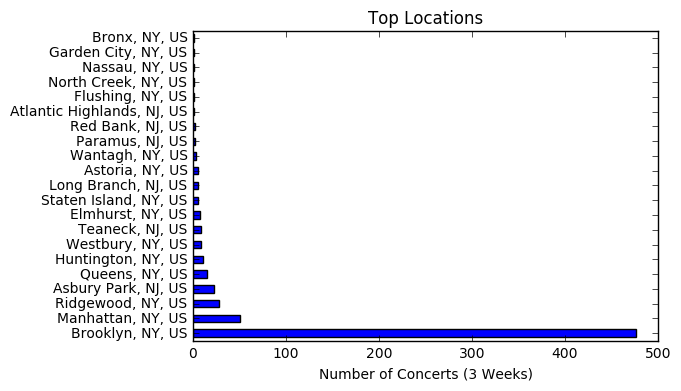

In [81]:
#plot of number of concerts per location in the NYC area.
myPlot1 = df['Location'].value_counts()[1:50].plot(kind='barh',title="Top Locations")
myPlot1.set_xlabel("Number of Concerts (3 Weeks)")

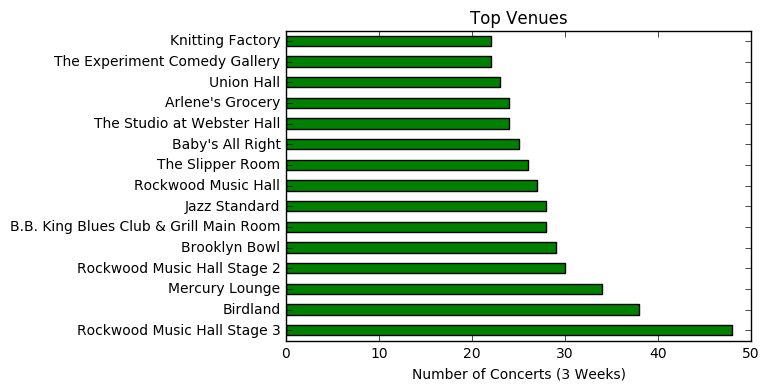

In [82]:
#plot the venues with most scheduled concerts
myPlot2 = df['Venue'].value_counts()[:15].plot(kind='barh',title="Top Venues", color="g")
myPlot2.set_xlabel("Number of Concerts (3 Weeks)")

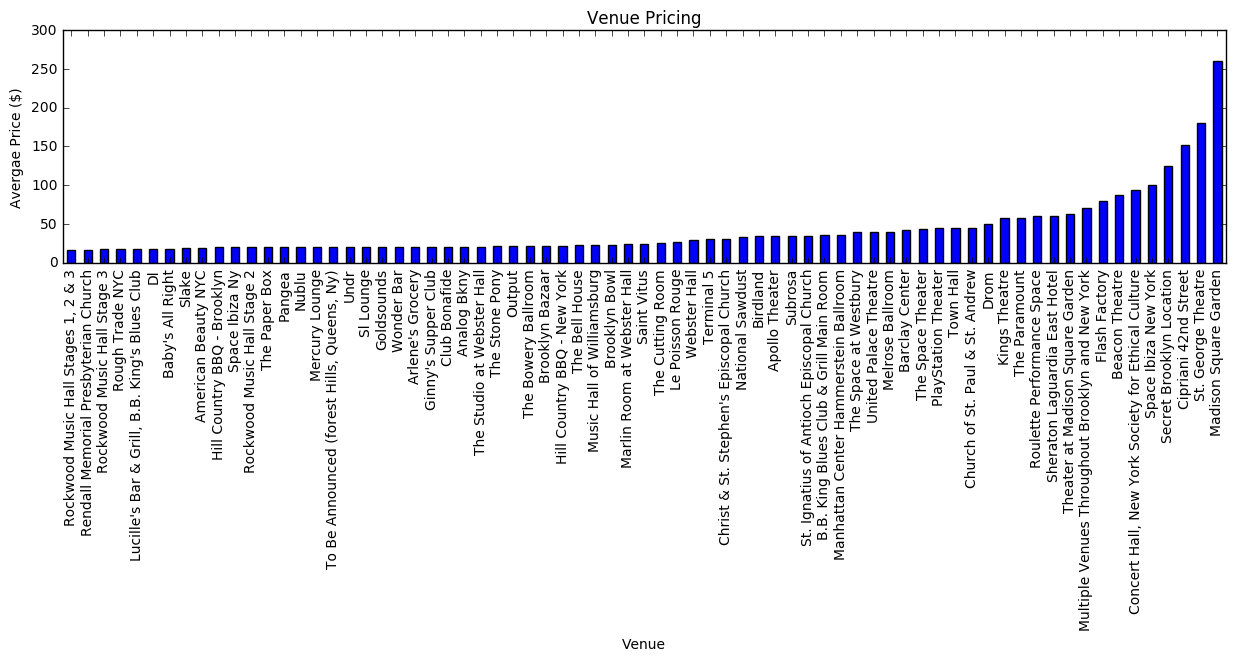

In [83]:
#find the average price per venue

venues = df[['Venue','Price']]
venues2 = venues[venues['Price'] > 15]

venue_group = venues2.groupby('Venue')
price_avg = venue_group['Price'].mean()

my_plot3 = price_avg.sort_values(axis=0).plot(kind='bar',legend=None,title="Venue Pricing",figsize=(15, 3))
my_plot3.set_ylabel("Avergae Price ($)")

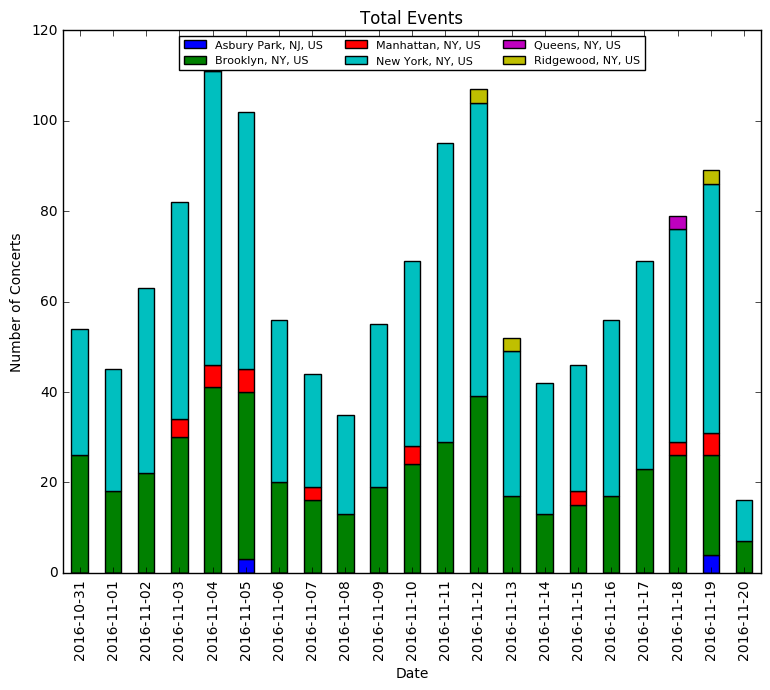

In [84]:
#Group concerts based on date and location and sum the number of events in every location
#plot total concerts by date and location
location_group = df.groupby(['Date','Location']).size()
location_group = location_group.loc[location_group > 2]

my_plot4 = location_group.unstack().plot(kind='bar',stacked=True,title="Total Events",figsize=(9, 7))
my_plot4.set_xlabel("Date")
my_plot4.set_ylabel("Number of Concerts")
my_plot4.legend(loc=9,ncol=3, fontsize=8)

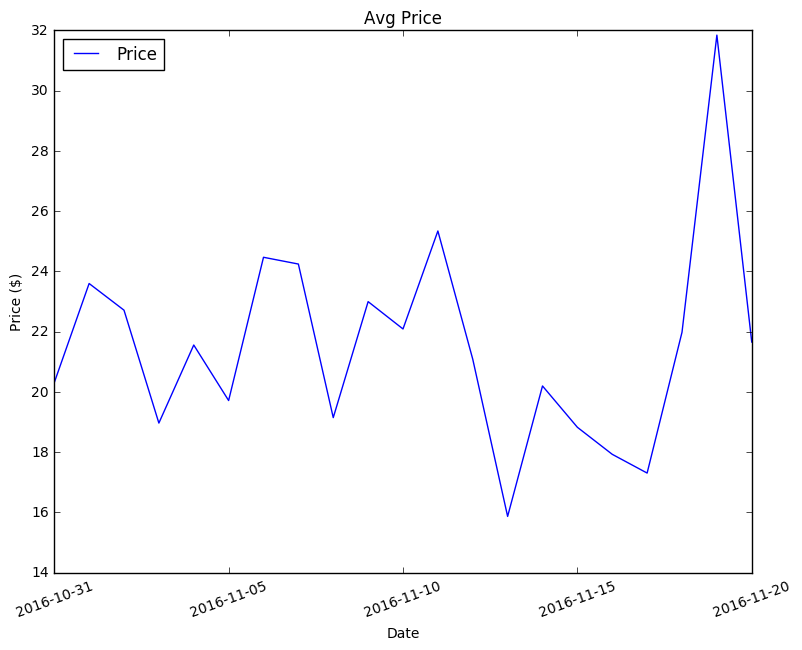

In [85]:
#plot the price changes over the three week time period.
prices = df[['Date','Price']]
price_patterns = prices.groupby(['Date']).mean()

my_plot5 = price_patterns.plot(kind='line',title="Avg Price",figsize=(9, 7),rot = 20)
my_plot5.set_xlabel("Date")
my_plot5.set_ylabel("Price ($)")

(1.0, 100.0)

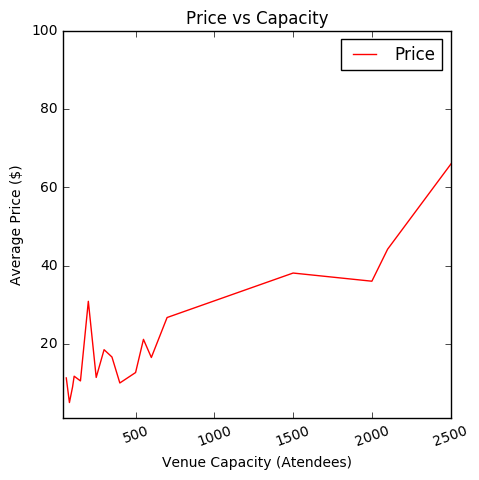

In [86]:
#plot the price change according to the concert's crowd size.
temp = df[['Size','Price']]
size_price = temp.groupby(['Size']).mean().dropna()

my_plot6 = size_price.plot(kind='line',title="Price vs Capacity",figsize=(5, 5),rot = 20, color="r")
my_plot6.set_xlabel("Venue Capacity (Atendees)")
my_plot6.set_ylabel("Average Price ($)")
plt.xlim(40.0,2500.0)
plt.ylim(1.0,100.0)

In [ ]:
con.close()